In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Load the .csv file
csv_file = 'C:\\Users\\Ashle\\OneDrive\\Desktop\\Lab codes\\2025 data\\carbenoxolone data\\carbenoxolone.csv' #ashleigh's personal computer
#csv_file = 'C:\\Users\\lab\\Documents\\src\\Ashleigh\\Data 2025\\carbenoxolone data\\carbenoxolone.csv' #lab computer

#Read CSV file
data = pd.read_csv(csv_file) #reads the file
#print(data)

#all scoring has been reviewed, graphs reflet true data


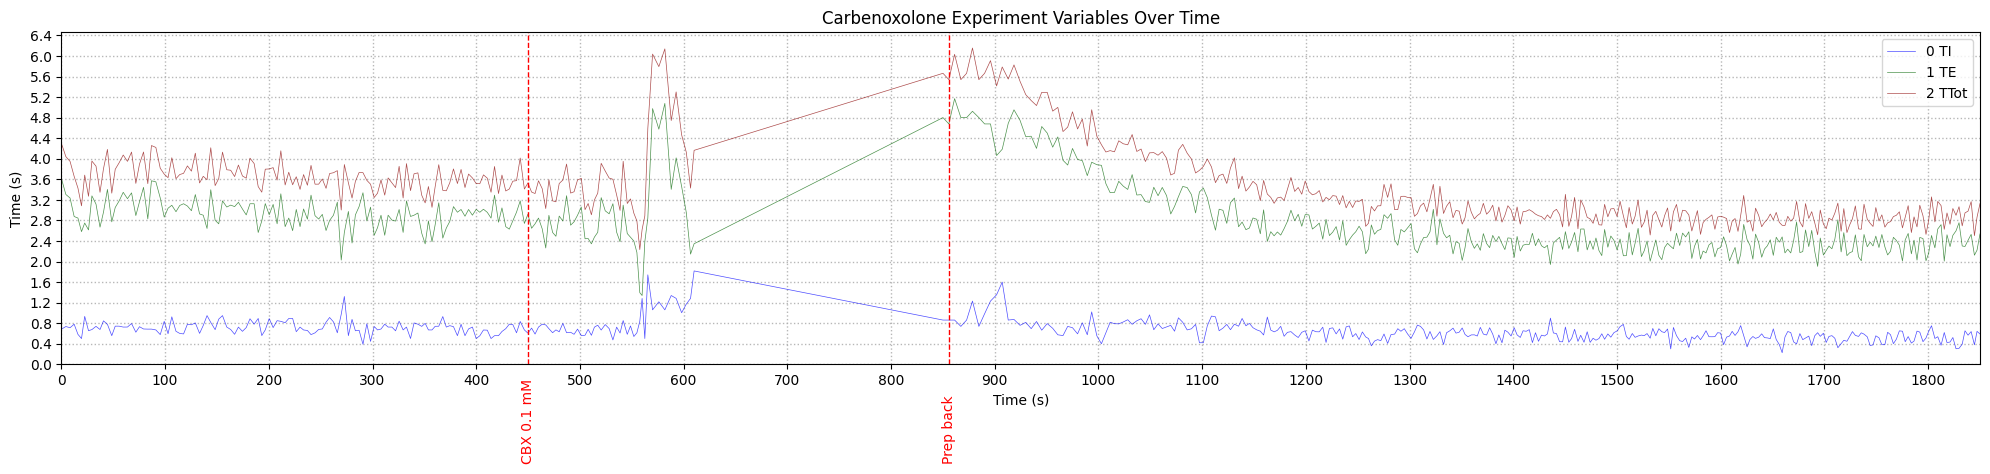

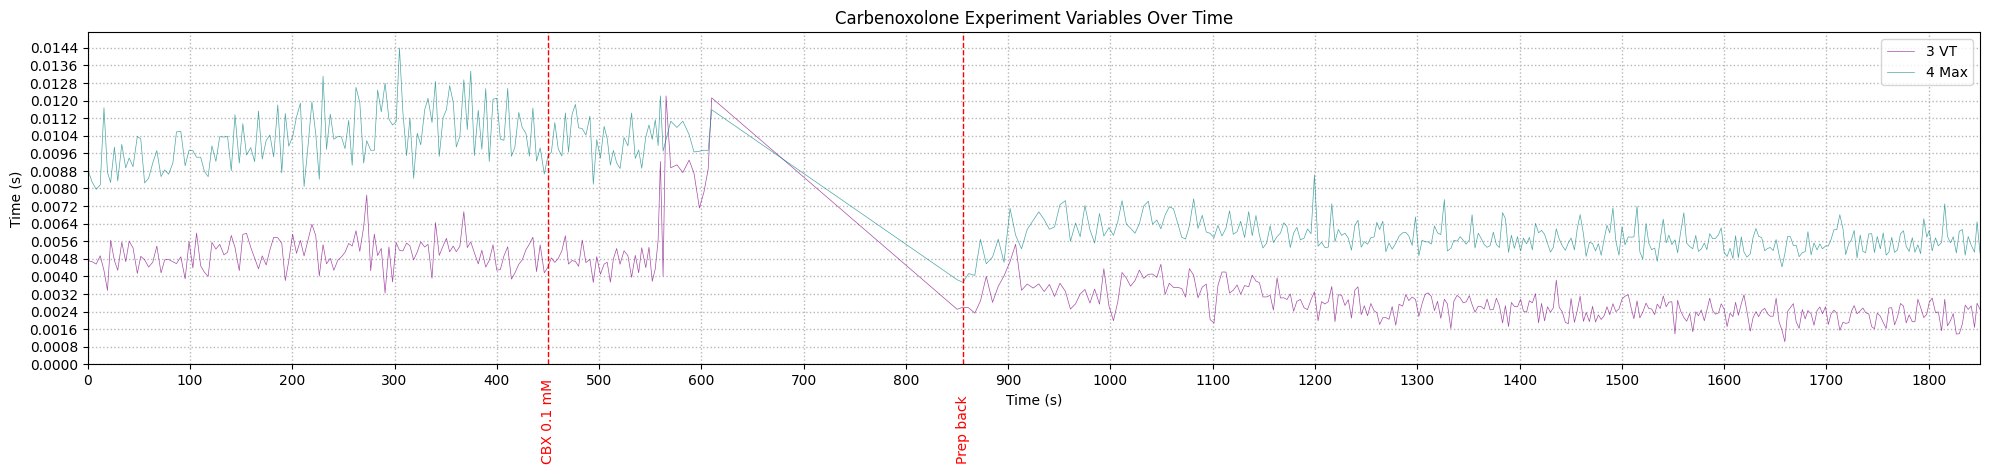

In [109]:
#group 1 variables plotted on same graph, group 2 variables plotted individually
group1 = ['0 TI', '1 TE', '2 TTot']
group2 = ['3 VT', '4 Max']

#color of data lines and trend lines for associated variables
colors_group1 = ['blue', 'darkgreen', 'darkred']
colors_group2 = ['purple', 'teal']

#time markers (in seconds) and their labels
event_times = [1800, 2700, 3600]
event_labels = ['30 mins', '45 mins', '60 mins']

#Adjust time for breaks in recording, first breath at time = 0, add gap for prep back
data = data.copy() #copies data to avoid modifying original dataframe
time_shifted = []
prep_down = 240   # 4-minute gap in seconds
prep_gap_breath = 167  # gap is added **after** this breath

for i, t in enumerate(data['Time']):
    if i == 0:
        # first breath starts at 0
        time_shifted.append(0)
        last_time = 0
    elif i <= prep_gap_breath:
        # breaths 1 through 167: subtract first breath time
        new_time = t - data['Time'].iloc[0]
        time_shifted.append(new_time)
        last_time = new_time
    elif i == prep_gap_breath + 1:
        # breath 168: add 4-minute gap after previous time
        new_time = last_time + prep_down
        time_shifted.append(new_time)
        last_time = new_time
    else:
        # breaths after 168: increment based on difference between recorded times
        delta = t - data['Time'].iloc[i-1]
        new_time = last_time + delta
        time_shifted.append(new_time)
        last_time = new_time

# add to dataframe
data['Time_shifted'] = time_shifted


#special events to mark on the graph
special_events = [
    {'x': data['Time_shifted'].iloc[123], 'label': 'CBX 0.1 mM', 'color': 'red', 'linestyle': '--'}, #(x = time that cbx was added)
    {'x': data['Time_shifted'].iloc[169], 'label': 'Prep back', 'color': 'red', 'linestyle': '--'}, #(x = time that prep came back on)
]

# #show time markers on graph
def add_vline_with_label(ax, x, label, color='black', linestyle='--', y=-0.3, fontsize=10):
    plt.axvline(x=x, color=color, linestyle=linestyle, linewidth=1)
    plt.text(
        x=x,
        y=y,
        s=label,
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='center',
        fontsize=fontsize,
        color=color,
        transform=ax.get_xaxis_transform()
        )

#function to plot
def plot_group(data, group, colors, event_times, event_labels, special_events, xlim=None, ylim=None):
    x = data['Time_shifted']
    plt.figure(figsize=(20, 5))
    for var, color in zip(group, colors):
        plt.plot(x, data[var], label=var, linewidth=0.5, alpha=0.7, color=color) # data line
        # coeffs = np.polyfit(x, data[var], 1)
        # trend = np.poly1d(coeffs)
        # plt.plot(x, trend(x), linestyle='--', alpha=0.7, label=f'{var} trend', color=color) # trend line
    
    ax = plt.gca()
    
    for t, label in zip(event_times, event_labels):
        if t <= max(data['Time_shifted']): #only add line if within data range
            idx = (np.abs(data['Time_shifted'] - t)).idxmin()
            #add_vline_with_label(ax, data['Time_shifted'][idx], label, color='black', linestyle=':')
    
    for ev in special_events:
        add_vline_with_label(ax, ev['x'], ev['label'], color=ev['color'], linestyle=ev['linestyle'])
    
    plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9) #grid behind graph
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.yaxis.set_major_locator(plt.MaxNLocator(20))
    
    ylim = (0, max(data[group].max())*1.05)
    xlim_seconds = max(data['Time_shifted'])
    xlim = (0, xlim_seconds)
    plt.ylim(ylim)
    plt.xlim(xlim)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Time (s)')
    plt.title('Carbenoxolone Experiment Variables Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()



plot_group(data, group1, colors_group1, event_times, event_labels, special_events)
plot_group(data, group2, colors_group2, event_times, event_labels, special_events)

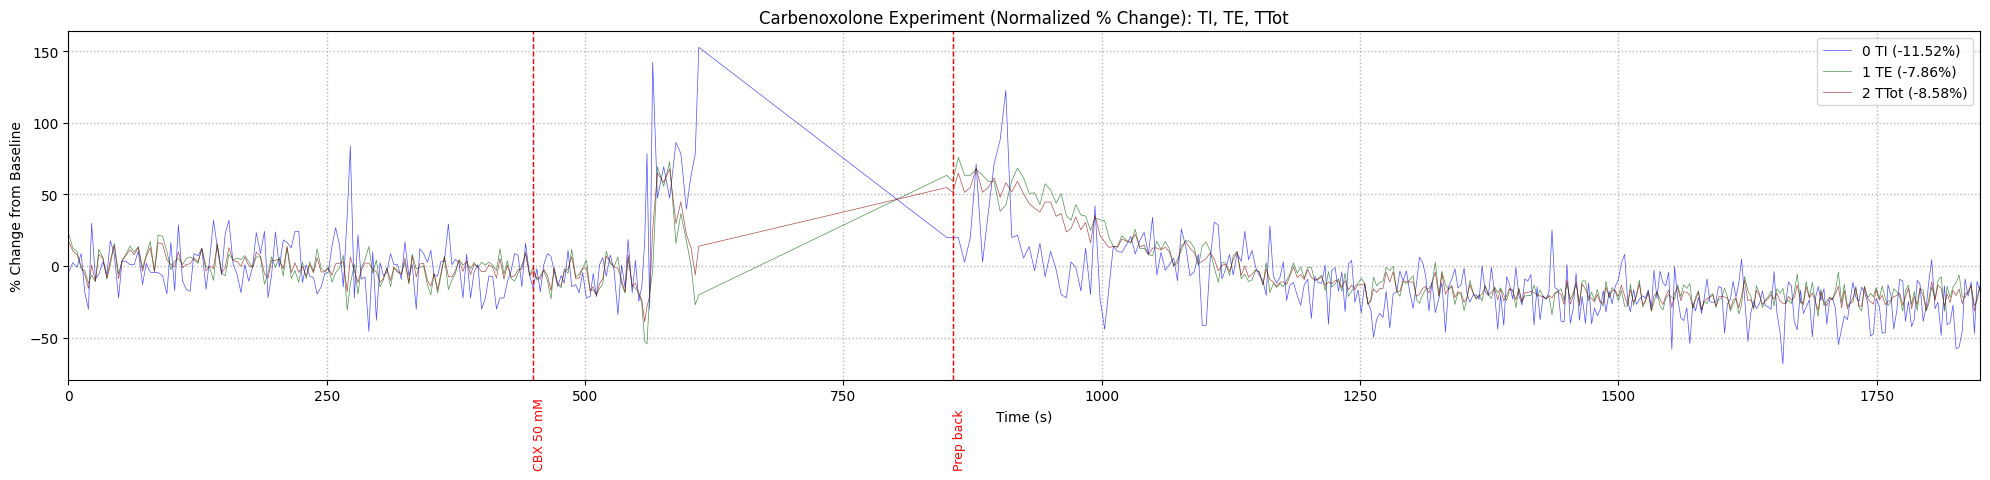

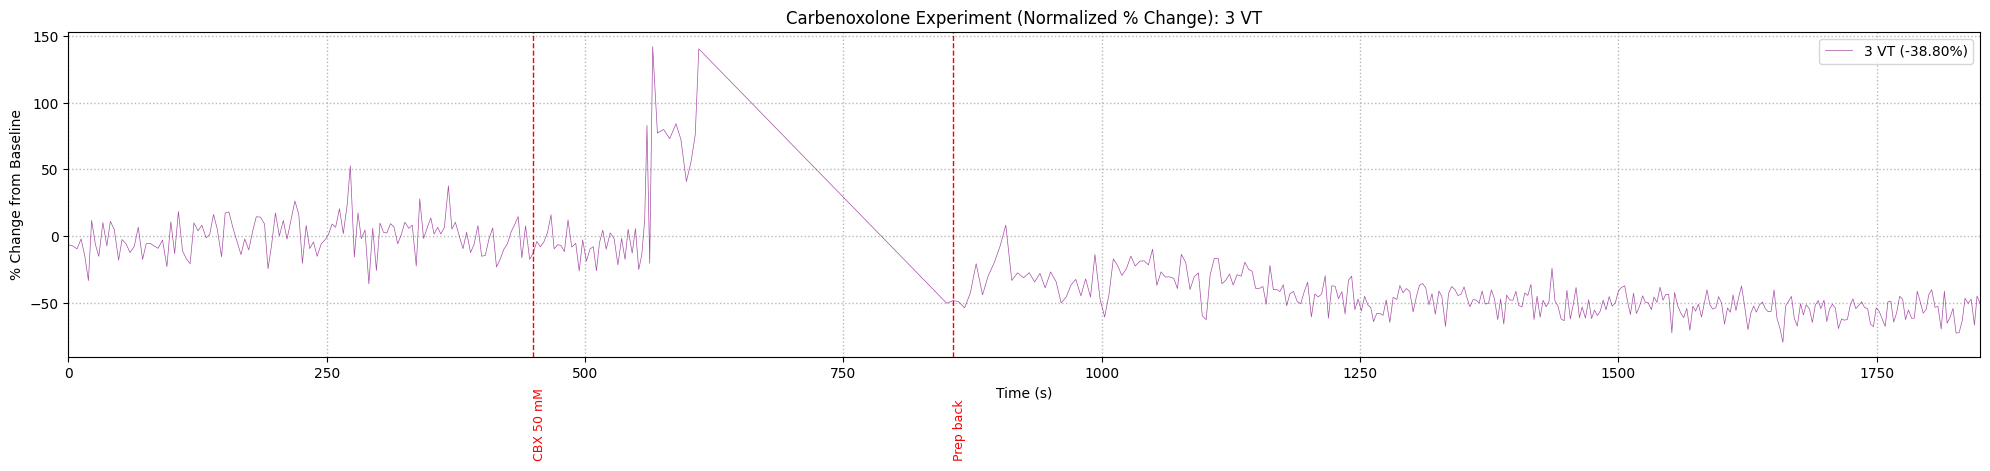

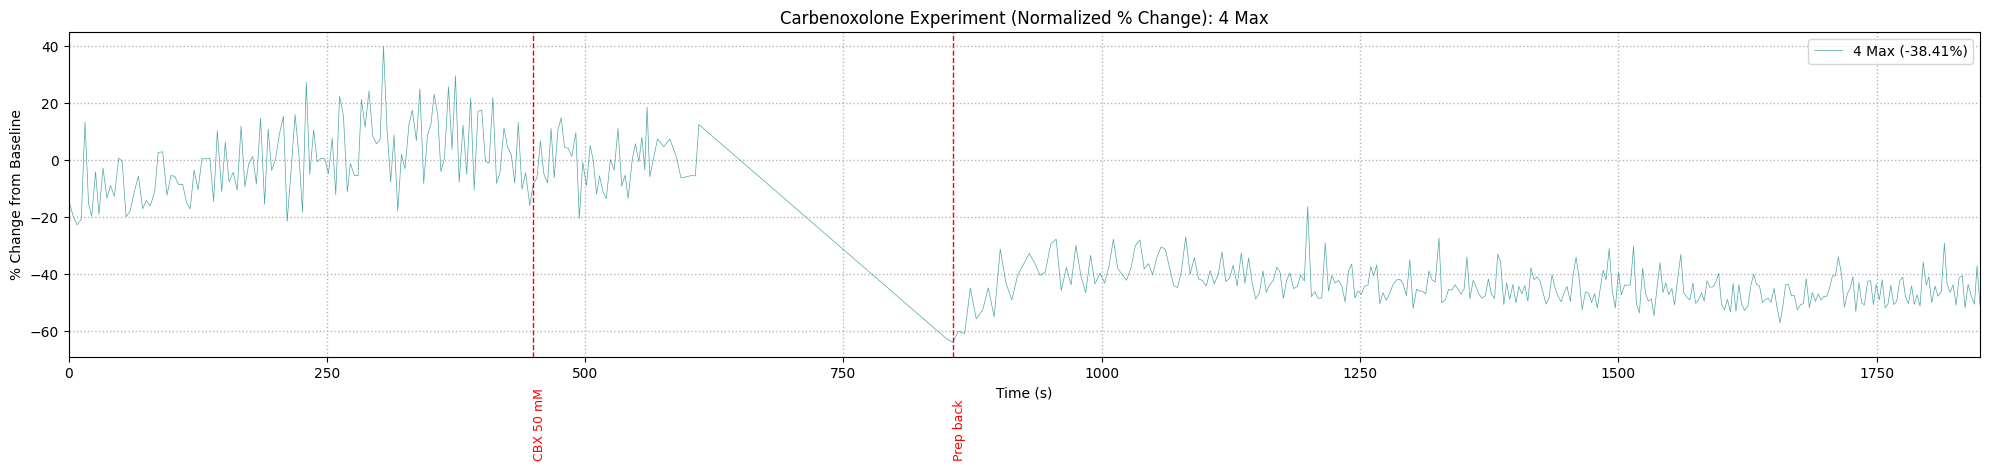

Normalized Mean % Change from Baseline:

0 TI: -11.52% change from baseline
1 TE: -7.86% change from baseline
2 TTot: -8.58% change from baseline
3 VT: -38.80% change from baseline
4 Max: -38.41% change from baseline


In [108]:
#Normalized percent change from baseline calculation and plotting
baseline_range = (0, 122)
postdrug_range = (123, len(data))   #based on breath number

normalized_data = data.copy() #make a copy of the data to hold normalized values

# normalize each variable to baseline mean
for var in group1 + group2:
    baseline_mean = data[var].iloc[baseline_range[0]:baseline_range[1]].mean()
    normalized_data[var] = (data[var] - baseline_mean) / baseline_mean * 100

# compute mean percent change across postdrug window (using integer indices)
percent_changes = {
    var: normalized_data[var].iloc[postdrug_range[0]:postdrug_range[1]].mean()
    for var in (group1 + group2)
}

x = data['Time_shifted']


# shared plotting function
def plot_normalized(var_list, color_list, title, y_offset):
    plt.figure(figsize=(20, 5))

    for var, color in zip(var_list, color_list):
        plt.plot(x, normalized_data[var], label=f"{var} ({percent_changes[var]:.2f}%)", linewidth=0.5, alpha=0.7, color=color)

        # coeffs = np.polyfit(x, normalized_data[var], 1)
        # trend = np.poly1d(coeffs)
        # plt.plot(x, trend(x), linestyle='--', alpha=0.7, label=f"{var} trend", color=color)

    ax = plt.gca()

    # special events (drug, prep return)
    for ev in special_events:
        plt.axvline(x=ev['x'], color=ev['color'], linestyle=ev['linestyle'], linewidth=1)
        plt.text( ev['x'], y_offset, ev['label'], transform=ax.get_xaxis_transform(), rotation=90, fontsize=9, color=ev['color'])

    plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9)
    plt.xlim([0, max(x)])
    plt.xlabel('Time (s)')
    plt.ylabel('% Change from Baseline')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plot group 1 variables together
plot_normalized(
    group1,
    colors_group1,
    'Carbenoxolone Experiment (Normalized % Change): TI, TE, TTot',
    -0.25 #location of labels on graph
)

# plot group 2 variables individually
for var, color in zip(group2, colors_group2):
    plot_normalized(
        [var],
        [color],
        f'Carbenoxolone Experiment (Normalized % Change): {var}',
        -0.31
    )

#print out the percent changes
print("Normalized Mean % Change from Baseline:\n")
for var, change in percent_changes.items():
    print(f"{var}: {change:.2f}% change from baseline")

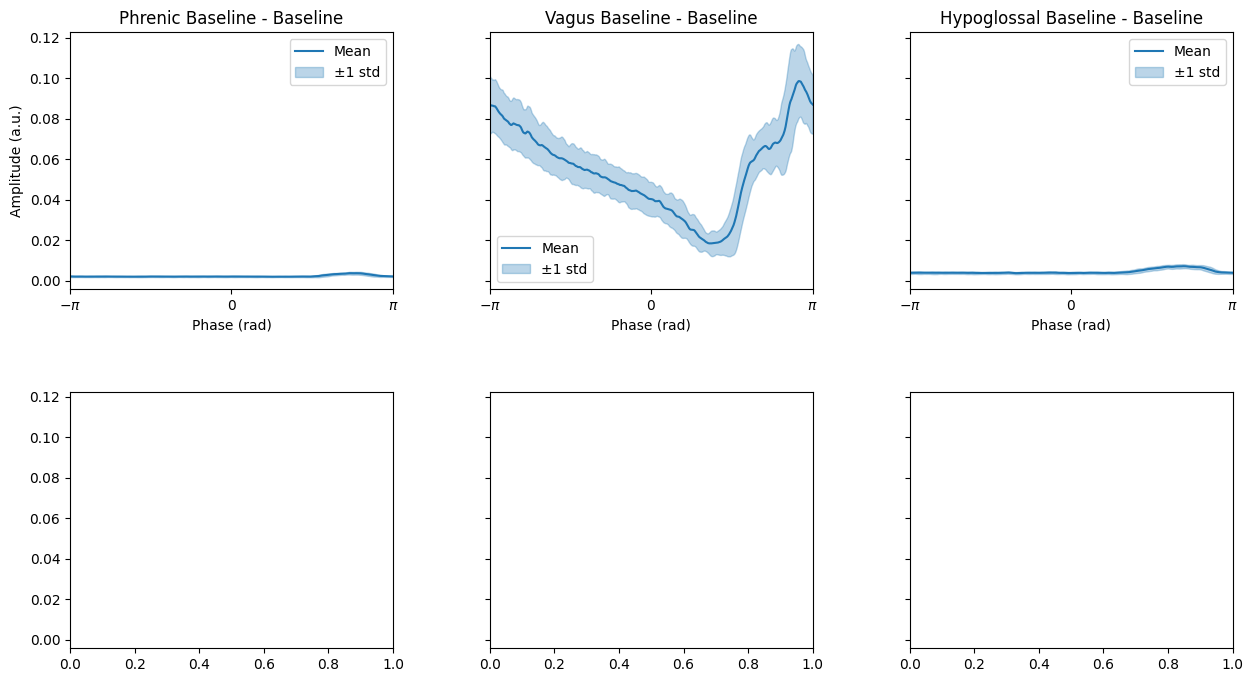

In [ ]:
import neo
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import quantities as pq



filename = r'C:\Users\Ashle\OneDrive\Desktop\Lab codes\2025 data\carbenoxolone data\250725 CBX 100 uM pt 1.smr'
reader = neo.io.Spike2IO(filename=filename)
block = reader.read_block()

block.segments[0].events
#print(block.segments[0].events)
insp_off = block.segments[0].events[2]
#print(insp_off.times[:10]) #prints first 10 ON event times to verify channel


# Load analog signals
pp = block.segments[0].analogsignals[0]  # pressure channel
mp = block.segments[0].analogsignals[1]  # motor pattern channels (4 total)

fs_mp = float(mp.sampling_rate)  #mp.sampling_rate gives rate that signal was recorded, gives as Hz
#print(fs_mp)

start_time = 1830  # float (no units)
end_time = 2295
start_sample = int(start_time* fs_mp) #converts start time to sampling index
end_sample = int(end_time * fs_mp)
#print(start_sample)

event_times = insp_off.times[(insp_off.times >= start_time) & (insp_off.times <= end_time)]
event_samples = ((event_times.rescale(pq.s).magnitude - start_time) * fs_mp).astype(int)
#print(event_samples[:10])

mp_segment = mp[start_sample:end_sample, :]  #finds the voltage of each channel starting at the start time, makes identifying channels easier
#print(mp_segment)
#Channel 1 : phrenic
#Channel 2 : vagus
#Channel 3 : hypoglossal

mp_segment_np = np.array(mp_segment) #converts to numpy array (rows are time points, columns are channels)
t_segment = np.arange(len(mp_segment_np)) / fs_mp + start_time #time vector for segment
#print(t_segment)

# start_idx = 0  # start of your segment
# end_idx = int(10 * fs_mp)  # first 10 seconds
# t_snip = t_segment[start_idx:end_idx]

# # create snippet arrays for channels 0..n-1
# mp_snip_np = mp_segment_np[start_idx:end_idx, :]  # shape (n_samples, n_channels)

high = 300  #Hz 
b, a = butter(3, high, btype='highpass', fs=fs_mp)

# preallocate arrays for all channels (snippet)
mp_hp_full = np.zeros_like(mp_segment_np) #preallocate arrays for all channels (full segment), high passed filter
mp_rect_full = np.zeros_like(mp_segment_np) #rectified (absolute value) filter preallocated array
mp_smooth_full = np.zeros_like(mp_segment_np) #smoothed/integrated filter preallocated array

for ch in range(mp_segment_np.shape[1]):
    mp_hp_full[:, ch] = filtfilt(b, a, mp_segment_np[:, ch])
    mp_rect_full[:, ch] = np.abs(mp_hp_full[:, ch])

tau = 50  # ms
wn = int(tau * 1e-3 * fs_mp)
if wn < 1:
    wn = 1
kernel = np.ones(wn) / wn

for ch in range(mp_segment_np.shape[1]):
    mp_smooth_full[:, ch] = filtfilt(kernel, [1], mp_rect_full[:, ch], padtype='even')

#for verifying plots:
# start_idx = 0  # start of preprocessed segment (from 1840s on raw data)
# end_idx = int(10 * fs_mp)  # first 10 seconds of samples
# t_snip = t_segment[start_idx:end_idx] #

# phrenic_preprocessed = mp_smooth_full[start_idx:end_idx, 0]  # Phrenic
# vagus_preprocessed= mp_smooth_full[start_idx:end_idx, 1]  # Vagus
# hypoglossal_preprocessed = mp_smooth_full[start_idx:end_idx, 2]  # Hypoglossal

# signals = [phrenic_preprocessed, vagus_preprocessed, hypoglossal_preprocessed]
# labels = ['Phrenic', 'Vagus', 'Hypoglossal']

# for sig, lab in zip(signals, labels):
#     plt.figure()
#     plt.plot(t_snip, sig)
#     plt.title(lab)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Voltage (a.u.)")
#     plt.show()



#CTA
n_bins = 1000  # number of points for each cycle
cta = np.zeros((3, n_bins))  #3 channels(P,V,H)

for i in range(len(event_samples) - 1): # -1 skips last event
    start_idx = event_samples[i] 
    end_idx = event_samples[i + 1]
    
    cycle_indices = np.linspace(start_idx, end_idx, num=n_bins).astype(int) #make n_bins evenly spaced points on teh cycle, all same size
    
    # add this cycle to the CTA for all 3 channels
    cta += mp_smooth_full[cycle_indices, :3].T  # transpose to match shape (3 x n_bins)
    
    # Verify the first cycle
    if i == 0:
        print("First cycle indices:", cycle_indices[:10], "...", cycle_indices[-10:])

n_cycles = len(event_samples) - 1
cta /= n_cycles #short hand for cta = cta / n_cycles
#cta = np.roll(cta, np.ceil(n_bins/2).astype(int))
cta = np.roll(cta, np.ceil(n_bins / 2).astype(int), axis=1) #center the CTA, axis=1 for time column

phi = np.linspace(-np.pi, np.pi, n_bins)

labels = ['Phrenic Baseline', 'Vagus Baseline', 'Hypoglossal Baseline']
for ch in range(3):
    plt.figure()
    plt.plot(phi, cta[ch])
    plt.xlim([-np.pi, np.pi])
    plt.xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$']    )
    plt.title(f'CTA - {labels[ch]}')
    plt.xlabel('Phase')
    plt.ylabel('Amplitude')
    plt.show()
